In [71]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Flatten

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns




In [72]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [73]:
df = pd.read_csv("Datasets/2023-10-11.csv")
df.head()


,Unnamed: 0,index,Coordinates,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,CMI_C07,...,CMI_C11,CMI_C12,CMI_C13,CMI_C14,CMI_C15,CMI_C16,ACM,BCM,Cloud_Probabilities,Lightning
0,0,0,"(44.28533797848896, -96.33244120270002)",0.169623,0.099563,0.375139,0.001111,0.195774,0.102440,298.40840,...,288.29090,257.63177,292.63490,292.07776,288.22775,269.13647,0.078123,0.000000,0.029264,0
1,1,1,"(44.16192918412268, -96.2790076055067)",0.180972,0.110357,0.416170,0.001071,0.207321,0.111607,298.71533,...,287.71057,257.37183,291.90130,291.38574,287.57257,268.87482,0.109530,0.000000,0.046814,0
2,2,2,"(44.03893135837276, -96.22611143587908)",0.240833,0.172460,0.445059,0.001111,0.238750,0.145952,298.25534,...,285.00128,255.86801,288.94000,288.50170,285.11570,267.86960,0.813740,0.094060,0.265362,0
3,3,3,"(43.916339862914086, -96.17374408076766)",0.245674,0.177897,0.430456,0.001587,0.237897,0.147659,298.69244,...,285.33386,256.09546,289.18967,288.67377,285.32043,267.93500,0.687891,0.093906,0.228131,0
4,4,4,"(43.794150142168, -96.1218971247137)",0.252857,0.182976,0.475952,0.001270,0.233353,0.140972,297.63165,...,284.73395,255.71437,288.62890,288.18744,284.90723,267.90747,0.797112,0.125466,0.303975,0


In [74]:
#Look at class imbalance

neg, pos = np.bincount(df['Lightning'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 937500
    Positive: 540 (0.06% of total)



In [75]:
features = ["CMI_C01", "CMI_C02", "CMI_C03","CMI_C04", "CMI_C05","CMI_C06", "CMI_C07","CMI_C15","Cloud_Probabilities","Lightning"]
#let's just do less features
#Predictors

copy_df = df.copy()
copy_df = copy_df[features]

X = copy_df[features]

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(copy_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Lightning'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Lightning'))
test_labels = np.array(test_df.pop('Lightning'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [76]:
#Averages are roughly similar

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0005
Average class probability in validation set: 0.0006
Average class probability in test set:       0.0007


In [77]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (600000,)
Validation labels shape: (150000,)
Test labels shape: (187500,)
Training features shape: (600000, 9)
Validation features shape: (150000, 9)
Test features shape: (187500, 9)


In [78]:
#Recommended parameters for imbalanced model

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
    keras.layers.Dense(len(features), activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dropout(0.5),
    #Output layer
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
])

  model.compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.FalsePositives(), tf.keras.metrics.Precision()])

  return model

In [79]:
EPOCHS = 128
BATCH_SIZE = 16384

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [80]:
initial_bias = np.log([pos/len(df)])
print(initial_bias)
model = make_model(output_bias=initial_bias)
model.summary()

[-7.4594029]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 10)                100       
                                                                 
 batch_normalization_11 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dense_67 (Dense)            (None, 16)                176       
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_68 (Dense)            (None, 8)                 136       
                                                                 
 dropout_45 (Dropout)        (None, 8)                 0         
                                        

In [81]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [82]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

2023-10-22 14:50:43.387027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loss: 0.0042


2023-10-22 14:50:45.884890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 340ms/step


array([[0.00041134],
       [0.00034539],
       [0.00069391],
       [0.00034064],
       [0.00145828],
       [0.00058739],
       [0.00116875],
       [0.00042583],
       [0.00153909],
       [0.00042853]], dtype=float32)

In [83]:
# model = make_model()
# model.load_weights(initial_weights)
# model.layers[-1].bias.assign([0.0])
# zero_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [84]:
# model = make_model()
# model.load_weights(initial_weights)
# careful_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [85]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [86]:
# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [87]:
def plot_metrics(history):
  metrics = ['loss', 'precision',]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [88]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

12/12 [==============================] - 0s 14ms/step


In [89]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [90]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 868.06


In [91]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
EPOCHS = 250
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=1)

Epoch 1/250


2023-10-22 14:50:47.121076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 3.7349 - false_positives_2: 29027.0000 - precision_13: 0.0019

2023-10-22 14:50:56.094060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 11s 176ms/step - loss: 3.7349 - false_positives_2: 29027.0000 - precision_13: 0.0019 - val_loss: 0.0046 - val_false_positives_2: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 2/250
37/37 [==============================] - 1s 18ms/step - loss: 3.4722 - false_positives_2: 25190.0000 - precision_13: 0.0027 - val_loss: 0.0049 - val_false_positives_2: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 1s 17ms/step - loss: 3.5876 - false_positives_2: 25216.0000 - precision_13: 0.0022 - val_loss: 0.0058 - val_false_positives_2: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 1s 17ms/step - loss: 3.3600 - false_positives_2: 25016.0000 - precision_13: 0.0025 - val_loss: 0.0063 - val_false_positives_2: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 1s 18ms/step - loss: 3.2183 - false_positives_2: 25627.0000 - precisi

In [92]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

2023-10-22 14:53:31.582196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step


12/12 [==============================] - 0s 7ms/step - loss: 0.3072 - false_positives_2: 23447.0000 - precision_13: 0.0043
loss :  0.30719923973083496
false_positives_2 :  23447.0
precision_13 :  0.004289111588150263

Legitimate Transactions Detected (True Negatives):  186059
Legitimate Transactions Incorrectly Detected (False Positives):  1315
Fraudulent Transactions Missed (False Negatives):  111
Fraudulent Transactions Detected (True Positives):  15
Total Fraudulent Transactions:  126


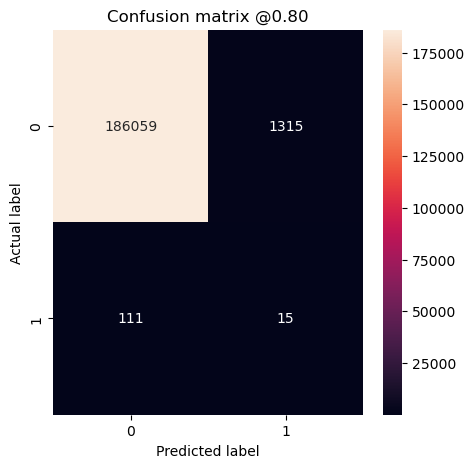

In [95]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted,threshold=0.8)